In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, make_scorer
import xgboost as xgb

## Import Data 

In [3]:
train = pd.read_csv('train_new.csv')
test = pd.read_csv('test_new.csv')

In [4]:
y = train.SalePrice
train = train.drop(columns=['Id', 'SalePrice'])

In [5]:
print(f'Train shape: {train.shape}')
print(f'Test shape: {test.shape}')

Train shape: (1451, 341)
Test shape: (1459, 341)


In [6]:
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size = 0.30, random_state=0)
print(f'X_train : {X_train.shape}')
print(f'X_test : {X_test.shape}')
print(f'y_train : {y_train.shape}')
print(f'y_test : {y_test.shape}')

X_train : (1015, 341)
X_test : (436, 341)
y_train : (1015,)
y_test : (436,)


In [7]:
stdSc = StandardScaler()
X_train = pd.DataFrame(stdSc.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test = pd.DataFrame(stdSc.transform(X_test), columns=X_test.columns, index=X_test.index)

In [8]:
scorer = make_scorer(mean_squared_error, greater_is_better=False)

def rmse_train(model):
    r = np.sqrt(-cross_val_score(model, X_train, y_train, scoring = scorer, cv = 10))
    return(r)
    
def rmse_test(model):
    r = np.sqrt(-cross_val_score(model, X_test, y_test, scoring = scorer, cv = 10))
    return(r)

In [ ]:
dtrain = xgb.DMatrix(X_train, label = y_train)
dtest = xgb.DMatrix(X_test)

params = {"max_depth":2, "eta":0.1}
model = xgb.cv(params, dtrain,  num_boost_round=500, early_stopping_rounds=100)

In [ ]:
model.loc[30:,["test-rmse-mean", "train-rmse-mean"]].plot()

In [ ]:
model_xgb = xgb.XGBRegressor(n_estimators=360, max_depth=2, learning_rate=0.1) #the params were tuned using xgb.cv
model_xgb.fit(X_train, y_train)

print(f'Training set rmse mean: {rmse_train(model_xgb).mean()}')
print(f'Cross validation set: {rmse_train(model_xgb).mean()}')

In [ ]:
train_pred = model_xgb.predict(X_train)
test_pred = model_xgb.predict(X_test)

In [ ]:
plt.style.use('seaborn')
plt.scatter(y_train, train_pred, label='Train', edgecolors='black')
plt.scatter(y_test, test_pred, label='CV', edgecolors='black')
plt.legend(loc=0)
plt.title('XGBoostRegressor')
plt.show()

In [ ]:
plt.scatter(train_pred, train_pred - y_train , label='Train', edgecolors='black')
plt.scatter(test_pred, test_pred - y_test, label='CV', edgecolors='black')
plt.legend(loc=0)
plt.title('XGBoostRegressor Errors')
plt.xlabel('Predicted Value')
plt.ylabel('Errors')
plt.show()

In [ ]:
xgb_preds = np.expm1(model_xgb.predict(X_test))

## XGBRegressor Hyperparameter Tuning
1. learning rate, default = 0.3
2. gamma, default = 0
3. max_depth, default = 6
4. lambda, default = 1
5. alpha, default = 0
6. min_child_weight, default = 1



In [9]:
from sklearn.model_selection import GridSearchCV

### n_estimator

In [10]:
n_estimators = [100,300,1000,3000]
param_grids = dict(n_estimators=n_estimators)
model = xgb.XGBRegressor(objective='reg:squarederror', nthread=-1, eta=0.1)

gridSearch = GridSearchCV(model, param_grids, scoring=scorer, cv=10)

In [11]:
gridResult = gridSearch.fit(X_train, y_train)

In [12]:
print("Best: %f using %s" % (gridResult.best_score_, gridResult.best_params_))

Best: -0.014012 using {'n_estimators': 1000}


In [13]:
means = gridResult.cv_results_['mean_test_score']
stds = gridResult.cv_results_['std_test_score']
params = gridResult.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

-0.014294 (0.003172) with: {'n_estimators': 100}
-0.014021 (0.003089) with: {'n_estimators': 300}
-0.014012 (0.003079) with: {'n_estimators': 1000}
-0.014012 (0.003079) with: {'n_estimators': 3000}


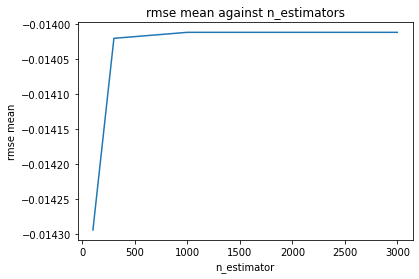

In [14]:
plt.plot(n_estimators, means)
plt.title('rmse mean against n_estimators')
plt.xlabel('n_estimator')
plt.ylabel('rmse mean')
plt.show()

In [ ]:
gridSearch

In [ ]:
gridResult

### Learning Rate

In [ ]:
eta = [0.01, 0.03, 0.1, 0.3, 1]
param_grids = dict(eta=eta)
model = xgb.XGBRegressor(n_estimators=150)

gridSearch = GridSearchCV(model, param_grids, scoring=scorer, cv=10)

In [ ]:
gridResult = gridSearch.fit(X_train, y_train)

In [ ]:
print("Best: %f using %s" % (gridResult.best_score_, gridResult.best_params_))
means = gridResult.cv_results_['mean_test_score']
stds = gridResult.cv_results_['std_test_score']
params = gridResult.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
plt.plot(eta, means)
plt.title('rmse mean against eta')
plt.xlabel('eta')
plt.ylabel('rmse')
plt.show()

## Gamma 

In [ ]:
gamma = [0, 1, 3, 10, 30, 100]
param_grids = dict(gamma=gamma)
model = xgb.XGBRegressor(n_estimators=150, eta=0.1)

gridSearch = GridSearchCV(model, param_grids, scoring=scorer, cv=10)

In [ ]:
gridResult = gridSearch.fit(X_train, y_train)

In [ ]:
print("Best: %f using %s" % (gridResult.best_score_, gridResult.best_params_))
means = gridResult.cv_results_['mean_test_score']
stds = gridResult.cv_results_['std_test_score']
params = gridResult.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
plt.plot(gamma, means)
plt.title('rmse mean against gamma')
plt.xlabel('gamma')
plt.ylabel('rmse')
plt.show()

## Max Depth 

In [ ]:
max_depth = [6,12,18,24]
param_grids = dict(max_depth=max_depth)
model = xgb.XGBRegressor(n_estimators=150, eta=0.1)

gridSearch = GridSearchCV(model, param_grids, scoring=scorer, cv=10)

In [ ]:
gridResult = gridSearch.fit(X_train, y_train)

In [ ]:
print("Best: %f using %s" % (gridResult.best_score_, gridResult.best_params_))
means = gridResult.cv_results_['mean_test_score']
stds = gridResult.cv_results_['std_test_score']
params = gridResult.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

plt.plot(max_depth, means)
plt.title('rmse mean against max_depth')
plt.xlabel('max_depth')
plt.ylabel('rmse')
plt.show()

## Lambda

In [ ]:
reg_lambda = [0.001, 0.03, 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30]
param_grids = dict(reg_lambda=reg_lambda)
model = xgb.XGBRegressor(n_estimators=150, eta=0.1)

gridSearch = GridSearchCV(model, param_grids, scoring=scorer, cv=10)

In [ ]:
gridResult = gridSearch.fit(X_train, y_train)

In [ ]:
print("Best: %f using %s" % (gridResult.best_score_, gridResult.best_params_))
means = gridResult.cv_results_['mean_test_score']
stds = gridResult.cv_results_['std_test_score']
params = gridResult.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

plt.plot(reg_lambda, means)
plt.title('rmse mean against reg_lambda')
plt.xlabel('reg_lambda')
plt.ylabel('rmse')
plt.show()

## Alpha 

In [ ]:
alpha = [0, 0.001, 0.03, 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30]
param_grids = dict(alpha=alpha)
model = xgb.XGBRegressor(n_estimators=150, eta=0.1)

gridSearch = GridSearchCV(model, param_grids, scoring=scorer, cv=10)

In [ ]:
gridResult = gridSearch.fit(X_train, y_train)

In [ ]:
print("Best: %f using %s" % (gridResult.best_score_, gridResult.best_params_))
means = gridResult.cv_results_['mean_test_score']
stds = gridResult.cv_results_['std_test_score']
params = gridResult.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

plt.plot(alpha, means)
plt.title('rmse mean against alpha')
plt.xlabel('alpha')
plt.ylabel('rmse')
plt.show()

## Min_child_weight 

In [21]:
min_child_weight = [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30]
param_grids = dict(min_child_weight=min_child_weight)
model = xgb.XGBRegressor(n_estimators=1000,
                         objective='reg:squarederror',
                         nthread=-1,
                         eta=0.1, 
                        )

gridSearch = GridSearchCV(model, param_grids, scoring=scorer, cv=10)

In [22]:
gridResult = gridSearch.fit(X_train, y_train)

Best: -0.013776 using {'min_child_weight': 10}
-0.014012 (0.003079) with: {'min_child_weight': 0.01}
-0.014012 (0.003079) with: {'min_child_weight': 0.03}
-0.014012 (0.003079) with: {'min_child_weight': 0.1}
-0.014012 (0.003079) with: {'min_child_weight': 0.3}
-0.014012 (0.003079) with: {'min_child_weight': 1}
-0.014350 (0.003347) with: {'min_child_weight': 3}
-0.013776 (0.003470) with: {'min_child_weight': 10}
-0.014504 (0.003161) with: {'min_child_weight': 30}


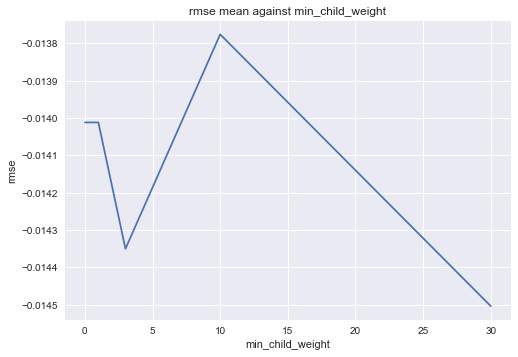

In [23]:
print("Best: %f using %s" % (gridResult.best_score_, gridResult.best_params_))
means = gridResult.cv_results_['mean_test_score']
stds = gridResult.cv_results_['std_test_score']
params = gridResult.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

plt.plot(min_child_weight, means)
plt.title('rmse mean against min_child_weight')
plt.xlabel('min_child_weight')
plt.ylabel('rmse')
plt.show()

n_estimator = 150, eta = 0.1, min_child_weight = 10



models.append(('xgb', XGBRegressor(learning_rate=0.01,n_estimators=3460,
                         max_depth=3, min_child_weight=0,
                         gamma=0, subsample=0.7,
                         colsample_bytree=0.7,
                         objective='reg:squarederror', nthread=-1,
                         scale_pos_weight=1, seed=27,
                         reg_alpha=0.00006)))

In [69]:
model = xgb.XGBRegressor(n_estimators=500,
                         objective='reg:squarederror',
                         max_depth=5,
                         nthread=-1,
                         eta=0.1, 
                         subsample=0.5,
                         colsample_bytree=0.7,
                         reg_lambda=0.1,
                         reg_alpha=3,
                         min_child_weight=0
                        )
model.fit(X_train, y_train)

# print(f'Training set rmse mean: {rmse_train(model).mean()}')
# print(f'Cross validation set: {rmse_train(model).mean()}')

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, eta=0.1, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.100000001, max_delta_step=0, max_depth=5,
             min_child_weight=0, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=4, nthread=-1, num_parallel_tree=1,
             random_state=0, reg_alpha=3, reg_lambda=0.1, scale_pos_weight=1,
             subsample=0.5, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [70]:
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

In [71]:
print(f'RMSE train: {mean_squared_error(y_train, train_pred, squared=False)}')
print(f'RMSE test: {mean_squared_error(y_test, test_pred, squared=False)}')

RMSE train: 0.08398417215179393
RMSE train: 0.11904137234349664


## reg_lambda and reg_alpha

In [75]:
reg_lambda=[0.01,0.03,0.1,0.3,1,3]
# reg_alpha=[0.01,0.03,0.1,0.3,1,3]

In [ ]:
scorer = make_scorer(mean_squared_error, greater_is_better=False)

def rmse_train(model):
    r = np.sqrt(-cross_val_score(model, X_train, y_train, scoring = scorer, cv = 10))
    return(r)
    
def rmse_test(model):
    r = np.sqrt(-cross_val_score(model, X_test, y_test, scoring = scorer, cv = 10))
    return(r)

Best: -0.013681 using {'reg_lambda': 0.3}
-0.014124 (0.002150) with: {'reg_lambda': 0.01}
-0.014008 (0.002045) with: {'reg_lambda': 0.03}
-0.014488 (0.001935) with: {'reg_lambda': 0.1}
-0.013681 (0.002415) with: {'reg_lambda': 0.3}
-0.014569 (0.002343) with: {'reg_lambda': 1}
-0.014992 (0.002221) with: {'reg_lambda': 3}


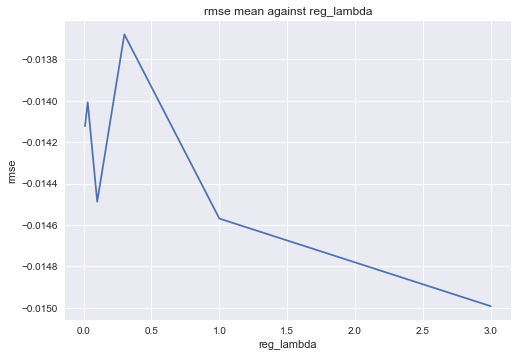

In [76]:
param_grids = dict(reg_lambda=reg_lambda,
#                    reg_alpha=reg_alpha
                  )
model = xgb.XGBRegressor(n_estimators=500,
                         objective='reg:squarederror',
                         max_depth=5,
                         nthread=-1,
                         eta=0.1, 
                         subsample=0.5,
                         colsample_bytree=0.7,
                         min_child_weight=0
                        )

gridSearch = GridSearchCV(model, param_grids, cv=5, scoring=scorer)

gridResult = gridSearch.fit(X_train, y_train)

print("Best: %f using %s" % (gridResult.best_score_, gridResult.best_params_))
means = gridResult.cv_results_['mean_test_score']
stds = gridResult.cv_results_['std_test_score']
params = gridResult.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

plt.plot(reg_lambda, means)
plt.title('rmse mean against reg_lambda')
plt.xlabel('reg_lambda')
plt.ylabel('rmse')
plt.show()

In [83]:
reg_lambda=[0.001,0.003,0.01,0.03,0.1,0.3,1,3,10,30]
reg_alpha=[0.001,0.003,0.01,0.03,0.1,0.3,1,3,10,30]
for l in range(0,10):
    for a in range(0,10):
        model = xgb.XGBRegressor(n_estimators=500,
                             objective='reg:squarederror',
                             max_depth=5,
                             nthread=-1,
                             eta=0.1, 
                             subsample=0.5,
                             colsample_bytree=0.7,
                             min_child_weight=0,
                             reg_lambda=reg_lambda[l],
                             reg_alpha=reg_alpha[a]
                            )
        print(f'lambda: {reg_lambda[l]}, alpha: {reg_alpha[a]}')
        model.fit(X_train,y_train)
        train_pred = model.predict(X_train)
        test_pred = model.predict(X_test)

        print(f'RMSE train: {mean_squared_error(y_train, train_pred, squared=False):.5}')
        print(f'RMSE test: {mean_squared_error(y_test, test_pred, squared=False):.5}')
        print('----------------------------')

lambda: 0.001, alpha: 0.001
RMSE train: 0.0039491
RMSE test: 0.11244
----------------------------
lambda: 0.001, alpha: 0.003
RMSE train: 0.0035521
RMSE test: 0.11742
----------------------------
lambda: 0.001, alpha: 0.01
RMSE train: 0.0039996
RMSE test: 0.11314
----------------------------
lambda: 0.001, alpha: 0.03
RMSE train: 0.0057976
RMSE test: 0.11709
----------------------------
lambda: 0.001, alpha: 0.1
RMSE train: 0.010997
RMSE test: 0.11598
----------------------------
lambda: 0.001, alpha: 0.3
RMSE train: 0.022221
RMSE test: 0.11444
----------------------------
lambda: 0.001, alpha: 1
RMSE train: 0.047725
RMSE test: 0.11277
----------------------------
lambda: 0.001, alpha: 3
RMSE train: 0.08362
RMSE test: 0.12083
----------------------------
lambda: 0.001, alpha: 10
RMSE train: 0.1262
RMSE test: 0.15033
----------------------------
lambda: 0.001, alpha: 30
RMSE train: 0.18593
RMSE test: 0.21773
----------------------------
lambda: 0.003, alpha: 0.001
RMSE train: 0.003939
R

RMSE train: 0.12598
RMSE test: 0.15062
----------------------------
lambda: 10, alpha: 30
RMSE train: 0.18608
RMSE test: 0.21589
----------------------------
lambda: 30, alpha: 0.001
RMSE train: 0.027068
RMSE test: 0.11693
----------------------------
lambda: 30, alpha: 0.003
RMSE train: 0.02695
RMSE test: 0.11757
----------------------------
lambda: 30, alpha: 0.01
RMSE train: 0.027179
RMSE test: 0.11609
----------------------------
lambda: 30, alpha: 0.03
RMSE train: 0.028007
RMSE test: 0.11671
----------------------------
lambda: 30, alpha: 0.1
RMSE train: 0.030607
RMSE test: 0.11538
----------------------------
lambda: 30, alpha: 0.3
RMSE train: 0.037592
RMSE test: 0.11168
----------------------------
lambda: 30, alpha: 1
RMSE train: 0.055274
RMSE test: 0.1183
----------------------------
lambda: 30, alpha: 3
RMSE train: 0.086606
RMSE test: 0.12472
----------------------------
lambda: 30, alpha: 10
RMSE train: 0.12945
RMSE test: 0.15119
----------------------------
lambda: 30, alph

In [81]:
a = 0.12345
print(f'{a:.4}')

0.1235


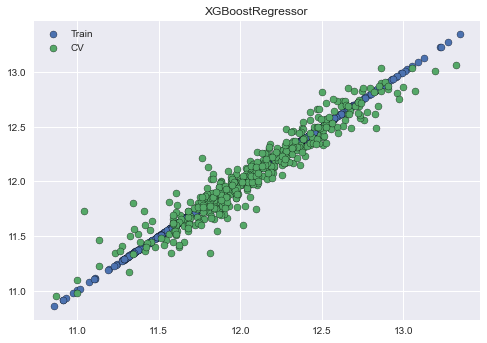

In [30]:
plt.style.use('seaborn')
plt.scatter(y_train, train_pred, label='Train', edgecolors='black')
plt.scatter(y_test, test_pred, label='CV', edgecolors='black')
plt.legend(loc=0)
plt.title('XGBoostRegressor')
plt.show()

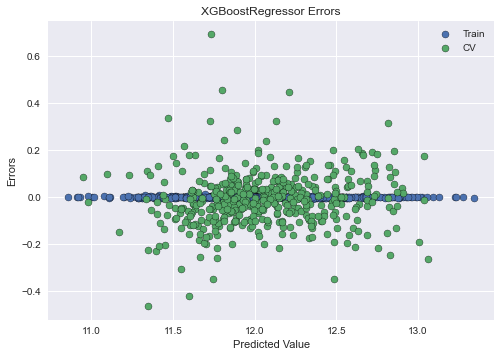

In [31]:
plt.scatter(train_pred, train_pred - y_train , label='Train', edgecolors='black')
plt.scatter(test_pred, test_pred - y_test, label='CV', edgecolors='black')
plt.legend(loc=0)
plt.title('XGBoostRegressor Errors')
plt.xlabel('Predicted Value')
plt.ylabel('Errors')
plt.show()

In [20]:
# xgb_preds = np.expm1(model_xgb.predict(X_test))

## Submission

In [ ]:
test = pd.read_csv('test_new.csv')
test = pd.DataFrame(stdSc.transform(test), columns=test.columns, index=test.index)
prediction = model.predict(test)
prediction

In [ ]:
prediction = np.expm1(prediction)
submission = pd.DataFrame(prediction, columns=['SalePrice'], index=pd.read_csv('test.csv').Id)
submission.head()

In [ ]:
submission.to_csv('August17_xgb.csv')